# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

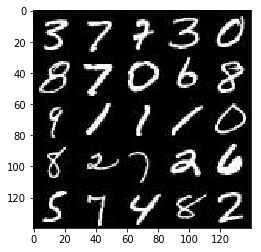

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

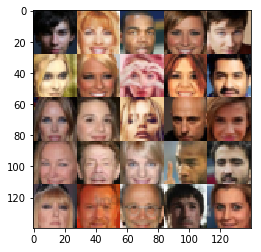

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [25]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    # input to our discriminator
    input_real = tf.placeholder(dtype=tf.float32, 
                                shape=(None,image_width, image_height, image_channels), name='input_real')
    
    # input to our generator network
    input_z = tf.placeholder(dtype=tf.float32, 
                             shape=(None, z_dim), name='input_z')
    
    # learning rate placeholder we will use later
    learning_rate =  tf.placeholder(dtype=tf.float32, shape=(), name='learning_rate')
    
    return input_real, input_z, learning_rate
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [26]:
import numpy as np

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # TODO: Implement Function
    # we build a convolutional network with 3 conv layers, increasing gradually the depth from 64 to 128 to 256
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # leaky relu :
        leak_factor = 0.15
        leaky_relu = lambda x: tf.maximum(leak_factor * x, x)
        
        layer1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, padding='same')
        layer1 = leaky_relu(layer1)
        layer1 = tf.nn.dropout(x=layer1, keep_prob=0.8)
        
        layer2 = tf.layers.conv2d(inputs=layer1, filters=128, kernel_size=5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = leaky_relu(layer2)
        layer2 = tf.nn.dropout(x=layer2, keep_prob=0.8)
        
        layer3 = tf.layers.conv2d(inputs=layer2, filters=256, kernel_size=5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = leaky_relu(layer3)
        layer3 = tf.nn.dropout(x=layer3, keep_prob=0.8)
        
        flat = tf.reshape(layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [54]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        leak_factor = 0.15
        leaky_relu = lambda x: tf.maximum(leak_factor * x, x)
        
        
        # first - dense layer from input z, then reshape to increase depth
        layer1 = tf.layers.dense(inputs=z, units=2*2*512)
        layer1 = tf.reshape(layer1, (-1, 2, 2, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(layer1)
        layer1 = tf.nn.dropout(x=layer1, keep_prob=0.5)
    
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, 2, 'valid')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = leaky_relu(layer2)
        layer2 = tf.nn.dropout(x=layer2, keep_prob=0.5)
    
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, 2, 'same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = leaky_relu(layer3)
        layer3 = tf.nn.dropout(x=layer3, keep_prob=0.5)
    
        # deconvolution
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [55]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    generator_model = generator(input_z, out_channel_dim, True)
    discriminator_model_real, discriminator_logits_real = discriminator(input_real)
    discriminator_model_fake, discriminator_logits_fake = discriminator(generator_model, reuse=True)
    
    
    # express the 2 components of the discriminator loss :
    # similar approach as in the previous lessons : sigmoid cross entropy with logits
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, 
                                                labels=tf.ones_like(discriminator_model_real)*0.9)) 
    # label smoothing as recommended by the reviewer - udacity rocks again

    
    discriminator_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_model_fake)))
    
    # generator loss : sigmoid 
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_model_fake)))
    
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake

    return discriminator_loss, generator_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [56]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # name trainable variables
    trainable_variables = tf.trainable_variables()
    discriminator_vars = [var for var in trainable_variables if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_variables if var.name.startswith('generator')]
    
    discriminator_train_optimizer = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
    
    # collect all ops for which the generator should be optimized and update it then
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(generator_updates):
        generator_train_optimizer = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=generator_vars)
        
    return discriminator_train_optimizer, generator_train_optimizer



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [57]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [58]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # get the tuple of inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    
    print("input_z :: ",type(input_z))
    print("input_z shape :: ",np.shape(input_z))
    print("z_dim :: ",z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        t0 = time.clock()
        
        # iterate over epoch_count
        for epoch_i in range(epoch_count):
            step = 0

            # batch through the mnist/celeb images
            for batch_images in get_batches(batch_size):
                step +=1
                batch_images *= 2
                
                # random generator input 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                # run the optimization for the generator twice to make sure that the discriminator loss does not go to zero
                # as suggested by uda*city reviewer - 
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if step % 30 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {} of {}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(step)," elapsed time - {:.2f}s ".format(time.clock() - t0),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # show images 
                if step % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

input_z ::  <class 'tensorflow.python.framework.ops.Tensor'>
input_z shape ::  (?, 128)
z_dim ::  128
Epoch 1 of 3... Batch 30...  elapsed time - 8.17s  Discriminator Loss: 1.7830... Generator Loss: 0.5928
Epoch 1 of 3... Batch 60...  elapsed time - 16.03s  Discriminator Loss: 1.6708... Generator Loss: 2.2400
Epoch 1 of 3... Batch 90...  elapsed time - 23.88s  Discriminator Loss: 0.9429... Generator Loss: 1.5179


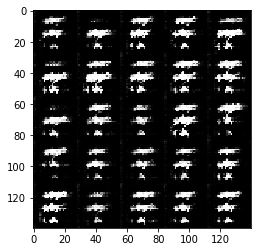

Epoch 1 of 3... Batch 120...  elapsed time - 32.67s  Discriminator Loss: 1.1334... Generator Loss: 1.5847
Epoch 1 of 3... Batch 150...  elapsed time - 40.59s  Discriminator Loss: 1.2023... Generator Loss: 2.4666
Epoch 1 of 3... Batch 180...  elapsed time - 48.52s  Discriminator Loss: 1.2256... Generator Loss: 0.9726


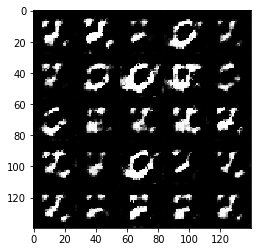

Epoch 1 of 3... Batch 210...  elapsed time - 57.34s  Discriminator Loss: 1.0610... Generator Loss: 2.0992
Epoch 1 of 3... Batch 240...  elapsed time - 65.27s  Discriminator Loss: 1.0520... Generator Loss: 1.3885
Epoch 1 of 3... Batch 270...  elapsed time - 73.18s  Discriminator Loss: 1.2983... Generator Loss: 0.7228
Epoch 1 of 3... Batch 300...  elapsed time - 81.11s  Discriminator Loss: 1.3460... Generator Loss: 0.7450


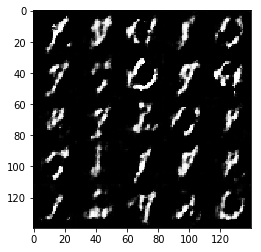

Epoch 1 of 3... Batch 330...  elapsed time - 89.98s  Discriminator Loss: 1.3311... Generator Loss: 1.0863
Epoch 1 of 3... Batch 360...  elapsed time - 97.93s  Discriminator Loss: 1.2125... Generator Loss: 1.5811
Epoch 1 of 3... Batch 390...  elapsed time - 105.88s  Discriminator Loss: 1.4903... Generator Loss: 2.4171


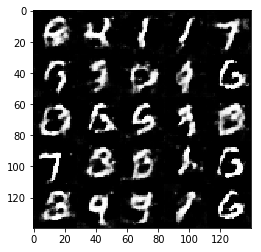

Epoch 1 of 3... Batch 420...  elapsed time - 114.71s  Discriminator Loss: 1.3770... Generator Loss: 1.7241
Epoch 1 of 3... Batch 450...  elapsed time - 122.65s  Discriminator Loss: 1.0656... Generator Loss: 1.6197
Epoch 2 of 3... Batch 30...  elapsed time - 135.27s  Discriminator Loss: 1.0915... Generator Loss: 1.6373
Epoch 2 of 3... Batch 60...  elapsed time - 143.18s  Discriminator Loss: 1.0522... Generator Loss: 1.1581
Epoch 2 of 3... Batch 90...  elapsed time - 151.14s  Discriminator Loss: 1.0009... Generator Loss: 1.4861


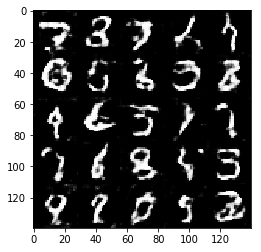

Epoch 2 of 3... Batch 120...  elapsed time - 159.98s  Discriminator Loss: 1.8481... Generator Loss: 0.3378
Epoch 2 of 3... Batch 150...  elapsed time - 167.92s  Discriminator Loss: 1.2785... Generator Loss: 0.7111
Epoch 2 of 3... Batch 180...  elapsed time - 175.85s  Discriminator Loss: 1.1267... Generator Loss: 1.5475


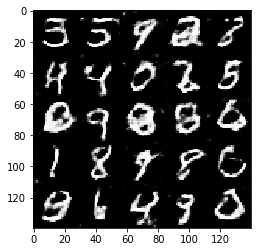

Epoch 2 of 3... Batch 210...  elapsed time - 184.66s  Discriminator Loss: 0.9712... Generator Loss: 1.0559
Epoch 2 of 3... Batch 240...  elapsed time - 192.53s  Discriminator Loss: 1.1414... Generator Loss: 0.7942
Epoch 2 of 3... Batch 270...  elapsed time - 200.46s  Discriminator Loss: 1.1781... Generator Loss: 2.1353
Epoch 2 of 3... Batch 300...  elapsed time - 208.40s  Discriminator Loss: 1.0458... Generator Loss: 1.2713


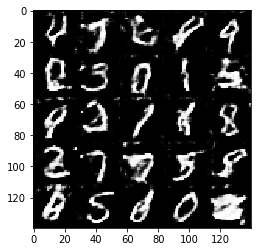

Epoch 2 of 3... Batch 330...  elapsed time - 217.23s  Discriminator Loss: 1.0037... Generator Loss: 1.2041
Epoch 2 of 3... Batch 360...  elapsed time - 225.16s  Discriminator Loss: 0.9294... Generator Loss: 1.1915
Epoch 2 of 3... Batch 390...  elapsed time - 233.10s  Discriminator Loss: 0.8868... Generator Loss: 1.6561


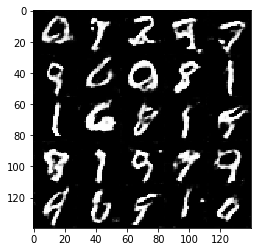

Epoch 2 of 3... Batch 420...  elapsed time - 242.31s  Discriminator Loss: 1.2825... Generator Loss: 0.7363
Epoch 2 of 3... Batch 450...  elapsed time - 250.28s  Discriminator Loss: 1.3136... Generator Loss: 0.7045
Epoch 3 of 3... Batch 30...  elapsed time - 262.96s  Discriminator Loss: 1.0256... Generator Loss: 2.0518
Epoch 3 of 3... Batch 60...  elapsed time - 270.93s  Discriminator Loss: 0.9470... Generator Loss: 1.3690
Epoch 3 of 3... Batch 90...  elapsed time - 278.87s  Discriminator Loss: 0.7691... Generator Loss: 1.3884


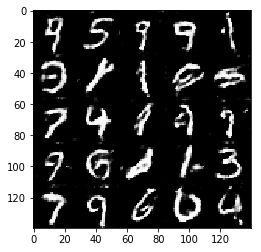

Epoch 3 of 3... Batch 120...  elapsed time - 287.66s  Discriminator Loss: 1.4249... Generator Loss: 0.6178
Epoch 3 of 3... Batch 150...  elapsed time - 295.60s  Discriminator Loss: 0.9233... Generator Loss: 1.2086
Epoch 3 of 3... Batch 180...  elapsed time - 303.54s  Discriminator Loss: 0.9211... Generator Loss: 2.4051


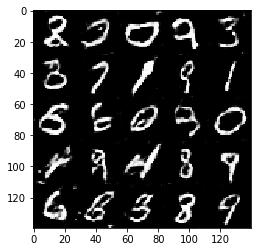

Epoch 3 of 3... Batch 210...  elapsed time - 312.42s  Discriminator Loss: 1.1034... Generator Loss: 3.1397
Epoch 3 of 3... Batch 240...  elapsed time - 320.31s  Discriminator Loss: 0.9056... Generator Loss: 1.2933
Epoch 3 of 3... Batch 270...  elapsed time - 328.24s  Discriminator Loss: 0.8222... Generator Loss: 1.0836
Epoch 3 of 3... Batch 300...  elapsed time - 336.15s  Discriminator Loss: 1.0824... Generator Loss: 3.1680


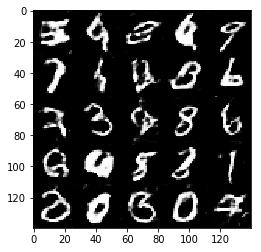

Epoch 3 of 3... Batch 330...  elapsed time - 344.99s  Discriminator Loss: 1.0797... Generator Loss: 2.5553
Epoch 3 of 3... Batch 360...  elapsed time - 352.93s  Discriminator Loss: 0.7323... Generator Loss: 1.3579
Epoch 3 of 3... Batch 390...  elapsed time - 360.86s  Discriminator Loss: 0.9040... Generator Loss: 1.6540


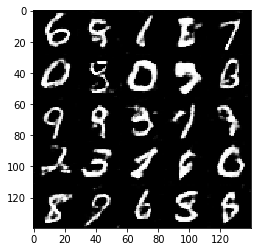

Epoch 3 of 3... Batch 420...  elapsed time - 369.74s  Discriminator Loss: 1.3714... Generator Loss: 0.6635
Epoch 3 of 3... Batch 450...  elapsed time - 377.66s  Discriminator Loss: 1.0248... Generator Loss: 0.9715


In [61]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

input_z ::  <class 'tensorflow.python.framework.ops.Tensor'>
input_z shape ::  (?, 50)
z_dim ::  50
Epoch 1 of 3... Batch 30...  elapsed time - 11.59s  Discriminator Loss: 0.7604... Generator Loss: 2.2384
Epoch 1 of 3... Batch 60...  elapsed time - 22.65s  Discriminator Loss: 0.6622... Generator Loss: 1.9554
Epoch 1 of 3... Batch 90...  elapsed time - 33.73s  Discriminator Loss: 0.6563... Generator Loss: 2.1493


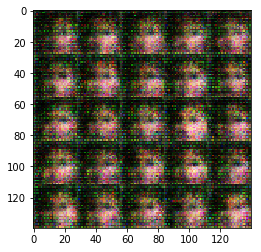

Epoch 1 of 3... Batch 120...  elapsed time - 45.77s  Discriminator Loss: 0.4696... Generator Loss: 3.6480
Epoch 1 of 3... Batch 150...  elapsed time - 56.86s  Discriminator Loss: 0.5515... Generator Loss: 2.6474
Epoch 1 of 3... Batch 180...  elapsed time - 67.95s  Discriminator Loss: 0.5306... Generator Loss: 2.9926


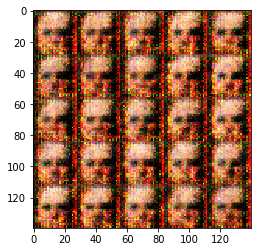

Epoch 1 of 3... Batch 210...  elapsed time - 79.97s  Discriminator Loss: 0.4644... Generator Loss: 3.3109
Epoch 1 of 3... Batch 240...  elapsed time - 91.09s  Discriminator Loss: 0.4749... Generator Loss: 3.2293
Epoch 1 of 3... Batch 270...  elapsed time - 102.16s  Discriminator Loss: 0.4369... Generator Loss: 3.4905
Epoch 1 of 3... Batch 300...  elapsed time - 113.24s  Discriminator Loss: 0.7304... Generator Loss: 2.5905


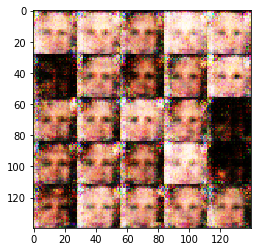

Epoch 1 of 3... Batch 330...  elapsed time - 125.28s  Discriminator Loss: 0.5293... Generator Loss: 3.2514
Epoch 1 of 3... Batch 360...  elapsed time - 136.37s  Discriminator Loss: 0.7246... Generator Loss: 4.6718
Epoch 1 of 3... Batch 390...  elapsed time - 147.41s  Discriminator Loss: 0.7127... Generator Loss: 1.8713


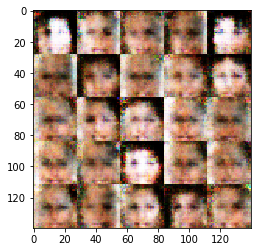

Epoch 1 of 3... Batch 420...  elapsed time - 159.34s  Discriminator Loss: 0.8803... Generator Loss: 3.1927
Epoch 1 of 3... Batch 450...  elapsed time - 170.42s  Discriminator Loss: 0.8716... Generator Loss: 1.4295
Epoch 1 of 3... Batch 480...  elapsed time - 181.48s  Discriminator Loss: 0.9717... Generator Loss: 1.5229


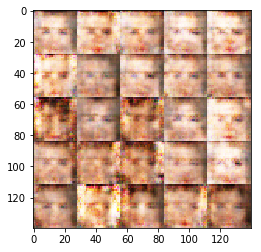

Epoch 1 of 3... Batch 510...  elapsed time - 193.50s  Discriminator Loss: 1.1063... Generator Loss: 1.3734
Epoch 1 of 3... Batch 540...  elapsed time - 204.55s  Discriminator Loss: 1.4610... Generator Loss: 1.3815
Epoch 1 of 3... Batch 570...  elapsed time - 215.61s  Discriminator Loss: 1.3361... Generator Loss: 1.3026
Epoch 1 of 3... Batch 600...  elapsed time - 226.70s  Discriminator Loss: 1.3714... Generator Loss: 1.1837


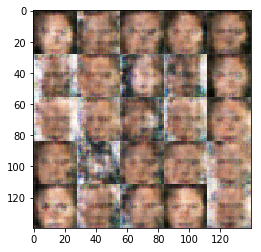

Epoch 1 of 3... Batch 630...  elapsed time - 238.70s  Discriminator Loss: 1.1096... Generator Loss: 1.4881
Epoch 1 of 3... Batch 660...  elapsed time - 249.72s  Discriminator Loss: 1.0071... Generator Loss: 1.4719
Epoch 1 of 3... Batch 690...  elapsed time - 260.74s  Discriminator Loss: 1.4142... Generator Loss: 1.0393


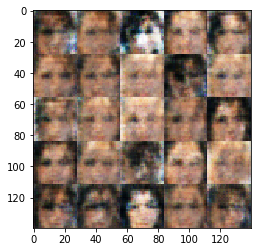

Epoch 1 of 3... Batch 720...  elapsed time - 272.75s  Discriminator Loss: 1.0820... Generator Loss: 1.4159
Epoch 1 of 3... Batch 750...  elapsed time - 283.77s  Discriminator Loss: 1.2384... Generator Loss: 1.3725
Epoch 1 of 3... Batch 780...  elapsed time - 294.82s  Discriminator Loss: 1.1855... Generator Loss: 1.2899


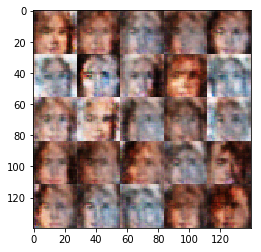

Epoch 1 of 3... Batch 810...  elapsed time - 306.82s  Discriminator Loss: 1.1166... Generator Loss: 1.4104
Epoch 1 of 3... Batch 840...  elapsed time - 317.87s  Discriminator Loss: 1.2086... Generator Loss: 1.3119
Epoch 1 of 3... Batch 870...  elapsed time - 328.94s  Discriminator Loss: 1.2066... Generator Loss: 1.3416
Epoch 1 of 3... Batch 900...  elapsed time - 339.98s  Discriminator Loss: 1.1602... Generator Loss: 1.5858


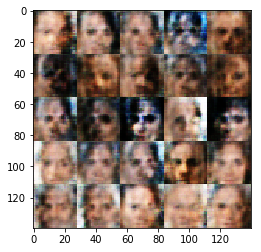

Epoch 1 of 3... Batch 930...  elapsed time - 352.49s  Discriminator Loss: 1.2512... Generator Loss: 1.1771
Epoch 1 of 3... Batch 960...  elapsed time - 363.58s  Discriminator Loss: 1.0784... Generator Loss: 1.4258
Epoch 1 of 3... Batch 990...  elapsed time - 374.67s  Discriminator Loss: 1.1236... Generator Loss: 1.5160


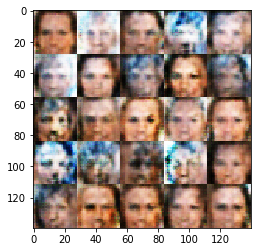

Epoch 1 of 3... Batch 1020...  elapsed time - 386.68s  Discriminator Loss: 1.3477... Generator Loss: 1.0605
Epoch 1 of 3... Batch 1050...  elapsed time - 397.76s  Discriminator Loss: 1.2248... Generator Loss: 1.1450
Epoch 1 of 3... Batch 1080...  elapsed time - 408.79s  Discriminator Loss: 1.1692... Generator Loss: 1.2358


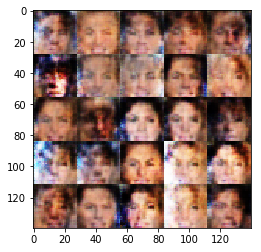

Epoch 1 of 3... Batch 1110...  elapsed time - 420.82s  Discriminator Loss: 1.1061... Generator Loss: 1.3450
Epoch 1 of 3... Batch 1140...  elapsed time - 431.94s  Discriminator Loss: 1.1827... Generator Loss: 1.4241
Epoch 1 of 3... Batch 1170...  elapsed time - 443.04s  Discriminator Loss: 1.2020... Generator Loss: 1.1769
Epoch 1 of 3... Batch 1200...  elapsed time - 454.10s  Discriminator Loss: 1.1644... Generator Loss: 1.1199


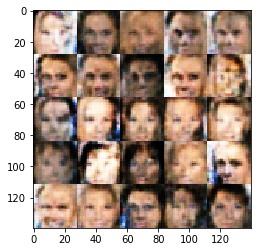

Epoch 1 of 3... Batch 1230...  elapsed time - 466.15s  Discriminator Loss: 1.1541... Generator Loss: 1.3008
Epoch 1 of 3... Batch 1260...  elapsed time - 477.21s  Discriminator Loss: 1.1897... Generator Loss: 1.1359
Epoch 1 of 3... Batch 1290...  elapsed time - 488.24s  Discriminator Loss: 0.9925... Generator Loss: 1.4213


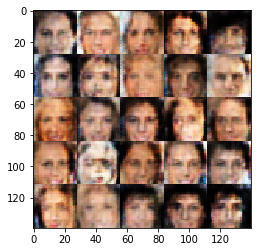

Epoch 1 of 3... Batch 1320...  elapsed time - 500.23s  Discriminator Loss: 1.1547... Generator Loss: 1.1788
Epoch 1 of 3... Batch 1350...  elapsed time - 511.34s  Discriminator Loss: 1.2660... Generator Loss: 1.1803
Epoch 1 of 3... Batch 1380...  elapsed time - 522.43s  Discriminator Loss: 1.1135... Generator Loss: 1.2775


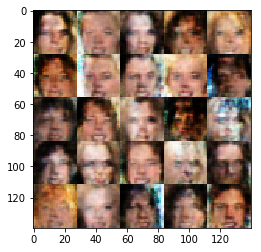

Epoch 1 of 3... Batch 1410...  elapsed time - 534.44s  Discriminator Loss: 1.1690... Generator Loss: 1.3771
Epoch 1 of 3... Batch 1440...  elapsed time - 545.51s  Discriminator Loss: 1.1111... Generator Loss: 1.1881
Epoch 1 of 3... Batch 1470...  elapsed time - 556.56s  Discriminator Loss: 1.0905... Generator Loss: 1.3431
Epoch 1 of 3... Batch 1500...  elapsed time - 567.62s  Discriminator Loss: 1.1413... Generator Loss: 1.1606


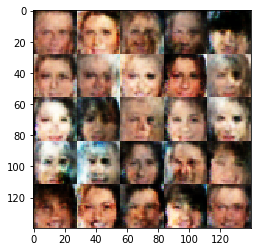

KeyboardInterrupt: 

In [60]:
batch_size = 128
z_dim = 50
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.